# Implementation of ResDMD with control

In [388]:
# Import python packages
import autograd.numpy as np
from scipy.linalg import logm
import matplotlib.pyplot as plt
import importlib

# Import files
import dynamic_models
import basis_functions
importlib.reload(dynamic_models)
importlib.reload(basis_functions)

<module 'basis_functions' from 'c:\\Users\\jonat\\OneDrive\\Documents\\GradYear2\\thesis_proj\\my_code\\ResDMDc\\basis_functions.py'>

### Choose model and dictionary of basis functions

In [389]:
model = dynamic_models.VanDerPol()  # Model choice

### Choose basis functions ###
obs_choice = 6  # if handmade basis is used
order = 6  # if (hermitian) polynomials are used
cross_terms = False

obs = basis_functions.Observables(obs_choice, order, cross_terms)
z = obs.handmade # choose which basis functions you want to use

num_obs = len(z(model.reset(), model.sample_input()))
print("size of dictionary: ", num_obs)

ballsack
size of dictionary:  5


## Collect trajectory data and compute EDMDc/ResDMDc

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\jonat\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\jonat\AppData\Local\Temp\ipykernel_12456\2899633903.py", line 22, in <module>
    xt_new = model.step(ut)
  File "c:\Users\jonat\OneDrive\Documents\GradYear2\thesis_proj\my_code\ResDMDc\dynamic_models.py", line 45, in step
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\jonat\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "C:\Users\jonat\AppData\Roaming\Python\Python310\site-packages\IPython\core\ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
  File "C:\Users\jonat\AppData\Roaming\Python\Python310\site

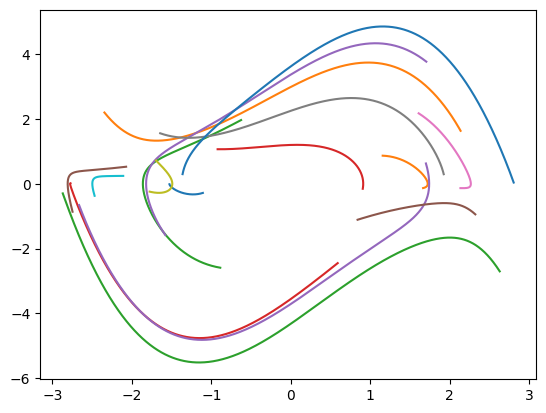

In [373]:
num_trials = 50 # number of resets
tf = 2
horizon = int(tf/model.dt) # how long we simulate the system for
M = num_trials * horizon # M sized data

training_traj = np.zeros([2, horizon, num_trials])
np.random.seed(420) # set the seed for reproducibility 

# EDMD matrices
A = np.zeros((num_obs, num_obs))
G = np.zeros((num_obs, num_obs))

# ResDMD matrices (only dependent on x observables)
A_x = np.zeros((num_obs-1, num_obs-1))
G_x = np.zeros((num_obs-1, num_obs-1))
L_x = np.zeros((num_obs-1, num_obs-1))

for k in range(num_trials):
    xt = model.reset()
    ut = model.sample_input()
    for t in range(horizon):
        xt_new = model.step(ut)
        ut_new = ut
        training_traj[:, t, k] = xt_new
 
        # EDMD computation for Koopman operator
        A += np.outer(z(xt, ut), z(xt_new, ut_new))
        G += np.outer(z(xt, ut), z(xt, ut))

        # ResDMD computation for eval errors
        z_xt = np.delete(z(xt, [0.]), -1)  # delete the control observable
        z_xt_new = np.delete(z(xt_new, [0.]), -1)  # delete the control observable
        A_x += np.outer(z_xt, z_xt_new)
        G_x += np.outer(z_xt, z_xt)
        L_x += np.outer(z_xt_new, z_xt_new)

        # reset for next loop
        xt = xt_new
        ut = ut_new

    plt.plot(training_traj[0,:,k], training_traj[1,:,k]) # plot trajectories used for training
A /= M
G /= M
A_x /= M
G_x /= M
L_x /= M

# koopman = np.linalg.pinv(G) @ A
koopman = (np.linalg.pinv(G) @ A).T  # to match Ian's results (which are slightly better)
koopman_edmd = np.linalg.pinv(G) @ A
cont_koopman = logm(koopman)/model.dt

# split apart koopman into A and B matrices
A = koopman[:num_obs-1,:num_obs-1]
B = koopman[:num_obs-1, num_obs-1:]

A_edmd = koopman_edmd[:num_obs-1,:num_obs-1]
B_edmd = koopman_edmd[:num_obs-1, num_obs-1:]

A_cont = cont_koopman[:num_obs-1,:num_obs-1]
B_cont = cont_koopman[:num_obs-1, num_obs-1:]

## Compute the residual, as defined in Matthew Colbrook's ResDMD

In [ ]:
evals, evecs = np.linalg.eig(A)
residuals = np.zeros(len(evals))

for i in range(len(evals)):
    evec_mat = np.asmatrix(evecs[:,i]).T
    lam = evals[i]
    numer = evec_mat.H@(L_x - lam*A_x.T - np.conj(lam)*A_x + np.absolute(lam)**2*G_x)@evec_mat
    denom = evec_mat.H@G_x@evec_mat
    residuals[i] = np.sqrt(np.real(numer[0,0])/np.real(denom[0,0]))

# Hamiltonian systems, identity eigenvaluet

## Analysis of results

|eval|:  0.9998683198372688 .......... res:  0.006046827579263633
|eval|:  0.9998683198372688 .......... res:  0.006046827579263633
|eval|:  0.999805697681672 .......... res:  0.004607559092839574
|eval|:  0.999805697681672 .......... res:  0.004607559092839574
|eval|:  0.9982572526954618 .......... res:  0.004159197972631958
|eval|:  0.9998448003017176 .......... res:  0.0034203829714054518
|eval|:  0.9995020704141135 .......... res:  0.0011086726003651098


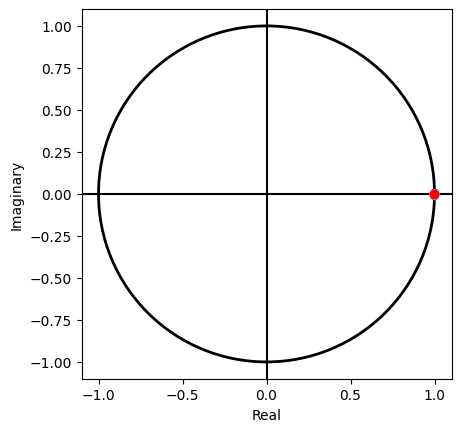

In [ ]:
# Print out the learned eigenvalues and their associated error
for i, eval in enumerate(evals):
    print("|eval|: ", np.absolute(eval), ".......... res: ", residuals[i])

# If the model is a linear system, compare ResDMD error with the known error
if model.name == "LinearSystem":
    for i, eval in enumerate(evals):
        a = np.abs(eval - model.evals[0])
        b = np.abs(eval - model.evals[1])
        print("Is residual faithful? ", min([a,b]) < residuals[i])

# Plot learned eigenvalues with the ResDMD error
fig, ax = plt.subplots()
plt.xlabel('Real')
plt.ylabel('Imaginary')

ax.set_aspect('equal', adjustable='box')
ax.axhline(y=0, color='k', zorder=0)
ax.axvline(x=0, color='k', zorder=0)
unit_circle = plt.Circle((0., 0.), 1, color='k', linewidth=2, fill=False, label='unit circle')
ax.add_patch(unit_circle)

color = plt.cm.rainbow(np.linspace(0, 1, len(evals)))
for i in range(len(evals)):
    circle = plt.Circle((evals[i].real, evals[i].imag), residuals[i], color=color[i], fill=False)
    ax.add_patch(circle)

# separate for loop so eigenvalues show up on top of everything
for i in range(len(evals)):
    plt.scatter(evals[i].real, evals[i].imag, color=color[i])

#### In the above plot, 
* Points represent the learned eigenvalues
* Circles with the same color correspond to the ResDMD error
* Black circle is the unit circle

Text(0.5, 1.0, 'Open Loop System')

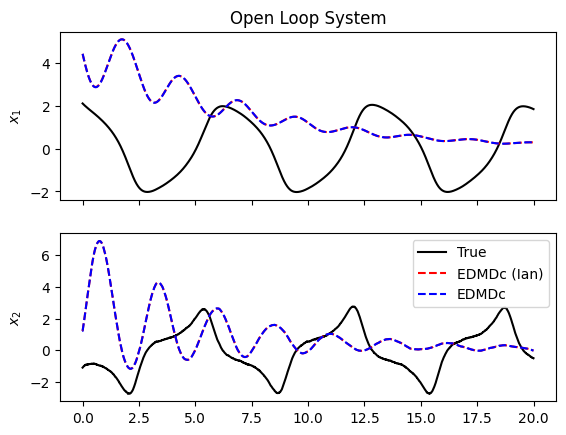

In [ ]:
simulation_tf = 20
simulation_horizon = int(simulation_tf/model.dt)

traj_test_true = np.zeros([2, simulation_horizon])
traj_test_koop = np.zeros([num_obs, simulation_horizon])
traj_test_koop_edmd = np.zeros([num_obs, simulation_horizon])
u_zero = [0.]  # for open loop trajectory

u_test = model.sample_input()

x0_rand = model.reset()
z0_rand = z(x0_rand, u_test)
traj_test_true[:, 0] = x0_rand
traj_test_koop[:, 0] = z0_rand
traj_test_koop_edmd[:, 0] = z0_rand

for t in range(simulation_horizon - 1):
    # propogate true dynamics
    traj_test_true[:, t+1] = model.step(u_test)

    # propogate Koopman dynamics
    traj_test_koop[:-1, t+1] = A@traj_test_koop[:-1, t] + B[:,0]*u_test

    traj_test_koop_edmd[:-1, t+1] = A_edmd@traj_test_koop[:-1, t] + B_edmd[:,0]*u_test

    # update input
    u_test = model.sample_input()


time = np.arange(0, simulation_tf, model.dt)

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(time, traj_test_true[0], 'k-', label="True")
axs[1].plot(time, traj_test_true[1], 'k-', label="True")
axs[0].plot(time, traj_test_koop[0], 'r--', label="EDMDc (Ian)")
axs[1].plot(time, traj_test_koop[1], 'r--', label="EDMDc (Ian)")
axs[0].plot(time, traj_test_koop_edmd[0], 'b--', label="EDMDc")
axs[1].plot(time, traj_test_koop_edmd[1], 'b--', label="EDMDc")
axs[0].set_ylabel('$x_1$')
axs[1].set_ylabel('$x_2$')
plt.legend()
axs[0].set_title("Open Loop System")


In [ ]:
print(x0_rand)
print(z0_rand)

[ 2.10133026 -1.10209276]
[ 4.41558888  1.21460844 -2.31586086  9.27861055 -1.33861116 -4.86638852
  2.55229348  0.53885922]


### Now for minimal-norm static state feedback!

In [ ]:
# these gains were generated by Gillis minimal-norm feedback optimization
K_ours = np.array([-0.0210, 0.4512, -0.0052, -0.3237])

model.reset(x0_rand)  #woah

traj_feedback_ours = np.zeros([2, simulation_horizon])
traj_feedback_ours[:, 0] = x0_rand


for t in range(simulation_horizon - 1):

    # create feedback
    u_ours = -K_ours@z(traj_feedback_ours[:, t], [0.])[:-1]

    # propogate true dynamics
    traj_feedback_ours[:, t+1] = model.step([u_ours])

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(time, traj_feedback_ours[0], 'k-', label="Ours")
axs[1].plot(time, traj_feedback_ours[1], 'k-', label="Ours")
axs[0].plot(time, traj_test_true[0], 'g--', label="open loop")
axs[1].plot(time, traj_test_true[1], 'g--', label="open loop")
axs[0].set_ylabel('$x_1$')
axs[1].set_ylabel('$x_2$')
axs[0].legend()
axs[0].set_title("Closed Loop System")

TypeError: VanDerPol.reset() takes 1 positional argument but 2 were given

In [ ]:
# these gains were generated by Gillis minimal-norm feedback optimization
K_min = np.array([-0.0001, 0.0990, -0.0002, -0.0097])

model.reset(x0_rand)  #woah

traj_feedback_min = np.zeros([2, simulation_horizon])
traj_feedback_min[:, 0] = x0_rand

for t in range(simulation_horizon - 1):
    # create feedback
    u_min = -K_min@z(traj_feedback_min[:, t], [0.])[:-1]

    # propogate true dynamics
    traj_feedback_min[:, t+1] = model.step([u_min])

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(time, traj_feedback_ours[0], 'k-', label="Ours")
axs[1].plot(time, traj_feedback_ours[1], 'k-', label="Ours")
axs[0].plot(time, traj_feedback_min[0], 'r--', label="min-norm")
axs[1].plot(time, traj_feedback_min[1], 'r--', label="min-norm")
axs[0].plot(time, traj_test_true[0], 'g--', label="open loop")
axs[1].plot(time, traj_test_true[1], 'g--', label="open loop")
axs[0].set_ylabel('$x_1$')
axs[1].set_ylabel('$x_2$')
axs[0].legend()
axs[0].set_title("Closed Loop System")

TypeError: VanDerPol.reset() takes 1 positional argument but 2 were given